In [1]:
import pandas as pd
import numpy  as np 

import matplotlib.pyplot as plt
import statistics as stat

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Setting seed

SEED = 101
np.random.seed(SEED)

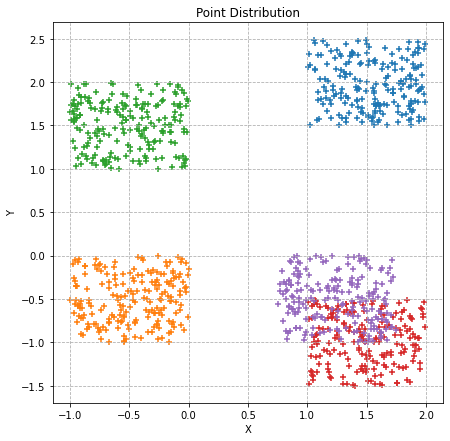

In [4]:
# Toy Dataset creation

## Creating a toy dataset

rand_values = np.random.rand(1000)

cluster_1 = np.array(list(zip( 1  + np.random.rand(200), 1.5 + np.random.rand(200))))
cluster_2 = np.array(list(zip( -1 + np.random.rand(200),  -1 + np.random.rand(200))))
cluster_3 = np.array(list(zip( -1 + np.random.rand(200),   1 + np.random.rand(200))))
cluster_4 = np.array(list(zip(  1 + np.random.rand(200),-1.5 + np.random.rand(200))))
cluster_5 = np.array(list(zip(.75 + np.random.rand(200),  -1 + np.random.rand(200))))

clusters = [cluster_1, cluster_2, cluster_3, cluster_4, cluster_5]

## Plotting the toy dataset

fig = plt.figure(figsize=(7, 7))
for cluster in clusters:
    plt.scatter(cluster[:,0], cluster[:,1], marker='+')
plt.grid(ls='--')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Point Distribution');

## Creating the toy dataframe

toy_df = pd.DataFrame()
for cluster_id, cluster in enumerate(clusters):
    sub_df = pd.DataFrame(cluster, columns=['x', 'y'])
    sub_df['cluster_id'] = cluster_id + 1
    toy_df = pd.concat([toy_df, sub_df])

In [5]:
# Naive Bayes Algorithm

## Caclulate mean and variance
def calc_mean_variance(X, y):
    mean = X.groupby(y).apply(np.mean).to_numpy()
    variance = X.groupby(y).apply(np.var).to_numpy() * (len(X) / (len(X) - 1))
    return mean, variance

## Calculate gaussian density
def gaussian_density(class_idx, mean, variance, x):
    class_mean = mean[class_idx]
    class_variance = variance[class_idx]
    
    numerator = np.exp((-0.5) * ((x - class_mean)**2) / (2 * class_variance))
    denominator = np.sqrt(2 * np.pi * class_variance)
    gaussian_density = numerator / denominator
    
    ### Variance Smoothing for zero probabilities
    for idx, x in enumerate(gaussian_density):
        if np.isnan(x):
            gaussian_density[idx] = 1e-9
        else:
            gaussian_density[idx] += 1e-9
    
    return gaussian_density

## Caclulate prior values
def calc_prior(X, y):
    prior = X.groupby(y).apply(lambda x: len(x)) / X.shape[0]
    prior = prior.to_numpy()
    return prior

## Caclulate posterior values
def calc_posterior(classes, mean, variance, prior_values, x):
    posteriors = []
    
    for class_idx in range(len(classes)):
        prior = np.log(prior_values[class_idx])
        conditional = np.sum(np.log(gaussian_density(class_idx, 
                                                     mean,
                                                     variance, x)))        
        posterior = prior + conditional             
        posteriors.append(posterior)
    return classes[np.argmax(posteriors)]

## Produce required predictions
def naive_bayes_predict(X_train, y_train, X_test):
    classes = np.unique(y_train)
    mean, variance = calc_mean_variance(X_train, y_train)
    prior_values = calc_prior(X_train, y_train)
    predictions = [calc_posterior(classes, mean, variance, prior_values, x) for x in X_test.values]
    
    return predictions

In [6]:
# Train Test Split

X = toy_df.drop(['cluster_id'], axis=1)
y = toy_df['cluster_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

In [7]:
# Coding the confusion matrix function

import seaborn as sns

def plot_confusion_matrix(y_train, y_test, y_predicted):
    labels = list(np.unique(y_train))
    cm = confusion_matrix(y_test, y_predicted, labels=labels)
    ax = sns.heatmap(cm, annot=True, annot_kws={"size": 16})
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels, rotation=0)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

In [8]:
%%time

# Our Naive Bayes Algorithm

m_naive_bayes_y_predicted = naive_bayes_predict(X_train, y_train, X_test)
m_naive_bayes_score = accuracy_score(y_test, m_naive_bayes_y_predicted)
print(f"Our Naive Bayes Test Set Accuracy Score: {m_naive_bayes_score:.3f}")
print(f"Training Data Count: {len(X_train)}, %Training Data: {100 * len(X_train)/len(X):.2f}")
print(f"Test Data Count: {len(X_test)}, %Test Data: {100 * len(X_test)/len(X):.2f}")

Our Naive Bayes Test Set Accuracy Score: 0.920
Training Data Count: 750, %Training Data: 75.00
Test Data Count: 250, %Test Data: 25.00
CPU times: user 42 ms, sys: 0 ns, total: 42 ms
Wall time: 40.6 ms


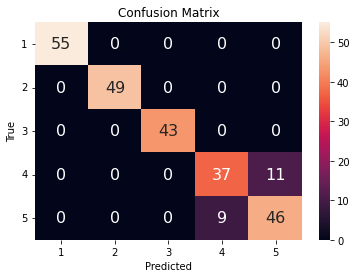

In [9]:
plot_confusion_matrix(y_train, y_test, m_naive_bayes_y_predicted)

Text(0.5, 0, 'X')

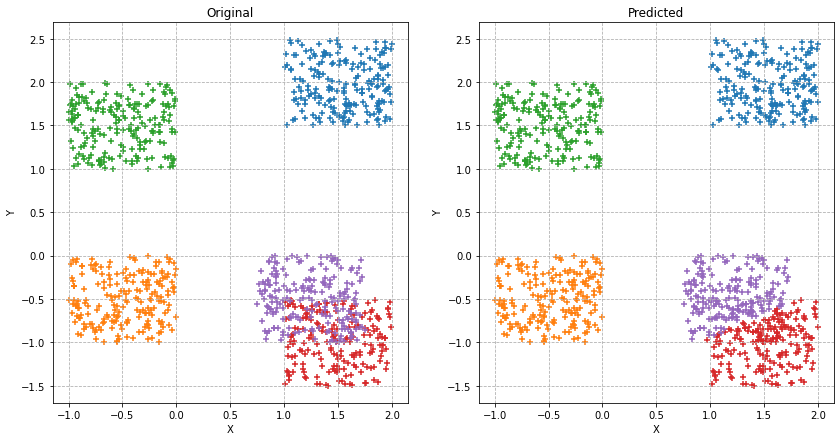

In [10]:
# Plotting Original vs Predicted for m_naive_bayes

m_naive_bayes_y_train_predicted = naive_bayes_predict(X_train, y_train, X_train)

train_df = X_train
train_df['cluster_id'] = m_naive_bayes_y_train_predicted

test_df = X_test
test_df['cluster_id']  = m_naive_bayes_y_predicted

main_df = pd.concat([X_train, X_test])

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for _, data in toy_df.groupby('cluster_id'):
    axs[0].scatter(data['x'], data['y'], marker='+')
axs[0].set_title("Original")
axs[0].grid(ls='--')
axs[0].set_ylabel('Y')
axs[0].set_xlabel('X')

for _, data in main_df.groupby('cluster_id'):
    axs[1].scatter(data['x'], data['y'], marker='+')
axs[1].set_title("Predicted")
axs[1].grid(ls='--')
axs[1].set_ylabel('Y')
axs[1].set_xlabel('X')

In [11]:
%%time

# Sci-Kit Learn's Naive Bayes Algorithm

nbayes_clf = GaussianNB()
nbayes_clf.fit(X_train, y_train)
sklearn_y_predicted = nbayes_clf.predict(X_test)
sklearn_y_predicted_score = accuracy_score(y_test, sklearn_y_predicted)
print(f"Sklearn's Naive Bayes Test Set Accuracy Score: {sklearn_y_predicted_score:.3f}")
print(f"Training Data Count: {len(X_train)}, %Training Data: {100 * len(X_train)/len(X):.2f}")
print(f"Test Data Count: {len(X_test)}, %Test Data: {100 * len(X_test)/len(X):.2f}")

Sklearn's Naive Bayes Test Set Accuracy Score: 0.920
Training Data Count: 750, %Training Data: 75.00
Test Data Count: 250, %Test Data: 25.00
CPU times: user 5.49 ms, sys: 0 ns, total: 5.49 ms
Wall time: 4.69 ms


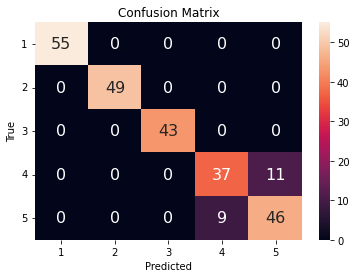

In [12]:
plot_confusion_matrix(y_train, y_test, sklearn_y_predicted)

In [13]:
# Loading Iris dataset

In [14]:
from sklearn.datasets import load_iris

irisData = load_iris()
 
X = pd.DataFrame(irisData.data)
y = irisData.target
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

In [15]:
%%time

# Our Naive Bayes Algorithm

m_naive_bayes_y_predicted = naive_bayes_predict(X_train, y_train, X_test)
m_naive_bayes_score = accuracy_score(y_test, m_naive_bayes_y_predicted)
print(f"Our Naive Bayes Test Set Accuracy Score: {m_naive_bayes_score:.3f}")
print(f"Training Data Count: {len(X_train)}, %Training Data: {100 * len(X_train)/len(X):.2f}")
print(f"Test Data Count: {len(X_test)}, %Test Data: {100 * len(X_test)/len(X):.2f}")

Our Naive Bayes Test Set Accuracy Score: 0.974
Training Data Count: 112, %Training Data: 74.67
Test Data Count: 38, %Test Data: 25.33
CPU times: user 12.6 ms, sys: 594 µs, total: 13.2 ms
Wall time: 11.9 ms


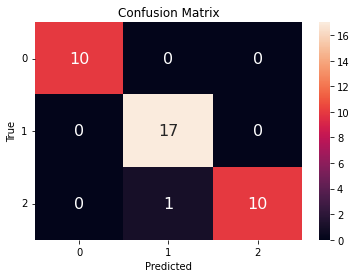

In [16]:
plot_confusion_matrix(y_train, y_test, m_naive_bayes_y_predicted)

In [17]:
%%time

# Sci-Kit Learn's Naive Bayes Algorithm

nbayes_clf = GaussianNB()
nbayes_clf.fit(X_train, y_train)
sklearn_y_predicted = nbayes_clf.predict(X_test)
sklearn_y_predicted_score = accuracy_score(y_test, sklearn_y_predicted)
print(f"Sklearn's Naive Bayes Test Set Accuracy Score: {sklearn_y_predicted_score:.3f}")
print(f"Training Data Count: {len(X_train)}, %Training Data: {100 * len(X_train)/len(X):.2f}")
print(f"Test Data Count: {len(X_test)}, %Test Data: {100 * len(X_test)/len(X):.2f}")

Sklearn's Naive Bayes Test Set Accuracy Score: 0.974
Training Data Count: 112, %Training Data: 74.67
Test Data Count: 38, %Test Data: 25.33
CPU times: user 3.41 ms, sys: 0 ns, total: 3.41 ms
Wall time: 2.98 ms


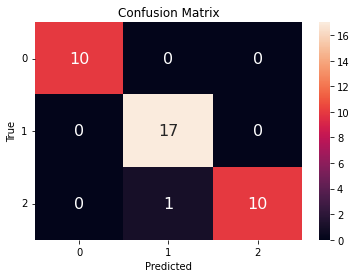

In [18]:
plot_confusion_matrix(y_train, y_test, sklearn_y_predicted)

In [19]:
# Load Car Dataset

In [20]:
carData = pd.read_csv('./car.data', encoding='utf-8', header=None)

carData.columns = ['buying', 'maintainence', 'doors', 'persons', 'lug_boot', 'safety', 'class']
carData = carData.replace({"class": {"unacc": 4, "acc": 3,'good': 2,'vgood':1}})

X = pd.get_dummies(carData.drop('class', axis=1))
y = carData['class']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

In [21]:
%%time

# Our Naive Bayes Algorithm

m_naive_bayes_y_predicted = naive_bayes_predict(X_train, y_train, X_test)
m_naive_bayes_score = accuracy_score(y_test, m_naive_bayes_y_predicted)
print(f"Our Naive Bayes Test Set Accuracy Score: {m_naive_bayes_score:.3f}")
print(f"Training Data Count: {len(X_train)}, %Training Data: {100 * len(X_train)/len(X):.2f}")
print(f"Test Data Count: {len(X_test)}, %Test Data: {100 * len(X_test)/len(X):.2f}")

Our Naive Bayes Test Set Accuracy Score: 0.722
Training Data Count: 1296, %Training Data: 75.00
Test Data Count: 432, %Test Data: 25.00
CPU times: user 127 ms, sys: 0 ns, total: 127 ms
Wall time: 126 ms


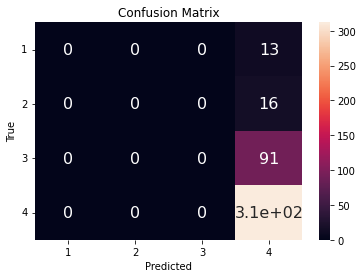

In [22]:
plot_confusion_matrix(y_train, y_test, m_naive_bayes_y_predicted)

In [23]:
%%time

# Sci-Kit Learn's Naive Bayes Algorithm

nbayes_clf = GaussianNB()
nbayes_clf.fit(X_train, y_train)
sklearn_y_predicted = nbayes_clf.predict(X_test)
sklearn_y_predicted_score = accuracy_score(y_test, sklearn_y_predicted)
print(f"Sklearn's Naive Bayes Test Set Accuracy Score: {sklearn_y_predicted_score:.3f}")
print(f"Training Data Count: {len(X_train)}, %Training Data: {100 * len(X_train)/len(X):.2f}")
print(f"Test Data Count: {len(X_test)}, %Test Data: {100 * len(X_test)/len(X):.2f}")

Sklearn's Naive Bayes Test Set Accuracy Score: 0.778
Training Data Count: 1296, %Training Data: 75.00
Test Data Count: 432, %Test Data: 25.00
CPU times: user 4.68 ms, sys: 534 µs, total: 5.21 ms
Wall time: 4.26 ms


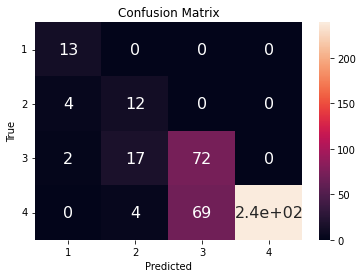

In [24]:
plot_confusion_matrix(y_train, y_test, sklearn_y_predicted)